In [2]:
import sys
import argparse
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

sys.path.append('Dataset')
from dataset import Dataset

sys.path.append('config')
import settings

sys.path.append('Preprocessing')
from preprocessing import LogoPreprocessing

sys.path.append('Models')
from xception import Xception

In [3]:
model = tf.keras.models.load_model("Artifacts/Models/v1/Model/tf")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [4]:
logoDataset = Dataset(
    data_path=settings.DATA_PATH,
    label_path=settings.LABELS_PATH,
    batch_size=settings.BATCH_SIZE
)

class_names = logoDataset.get_all_labels()

preprocessor = LogoPreprocessing(class_names, settings.IMAGE_HEIGHT, settings.IMAGE_WIDTH)
(train_ds, val_ds, test_ds) = logoDataset.create_data_pipelines(preprocessor)

In [4]:
model.evaluate(test_ds)

200/200 [==============================] - 55s 270ms/step - loss: 0.1155 - accuracy: 0.9800


[0.11546775698661804, 0.9800000190734863]

1/1 [==============================] - 0s 313ms/step


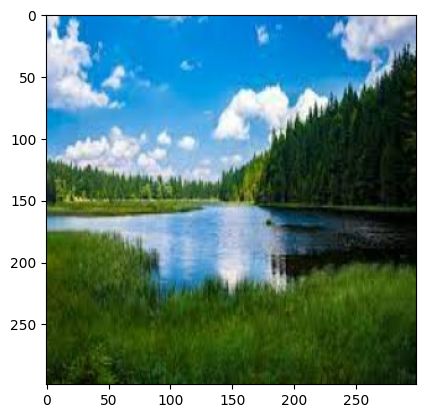

True label = Others
Predicted label = Others


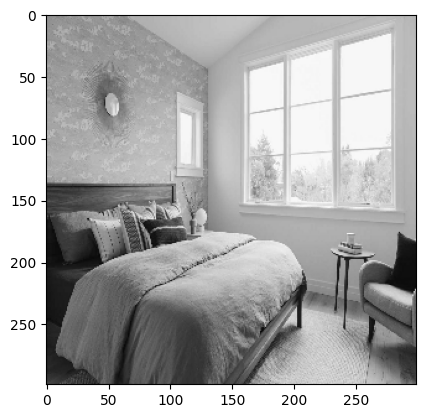

True label = Others
Predicted label = Others
1/1 [==============================] - 0s 308ms/step


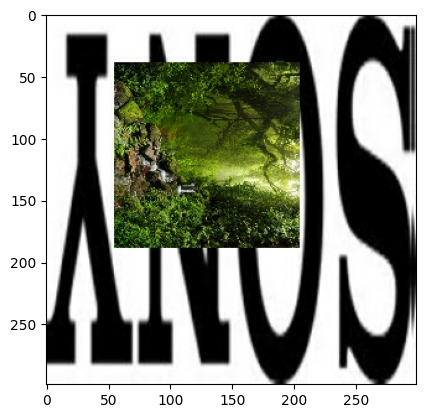

True label = Others
Predicted label = Others


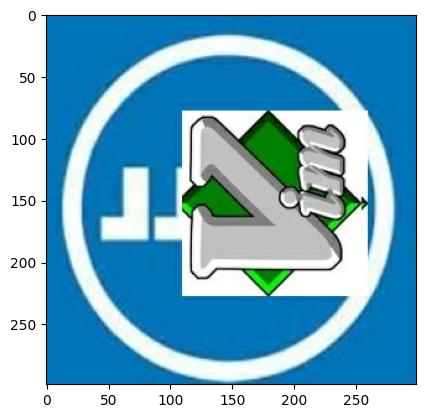

True label = Others
Predicted label = Others
1/1 [==============================] - 0s 320ms/step


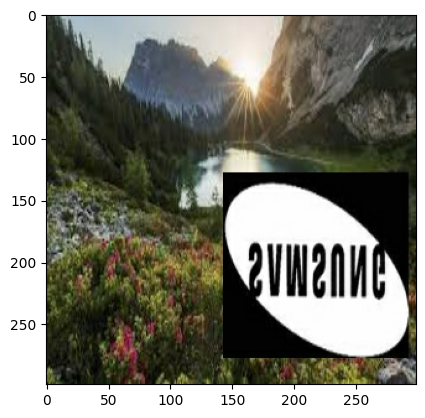

True label = Samsung
Predicted label = Samsung


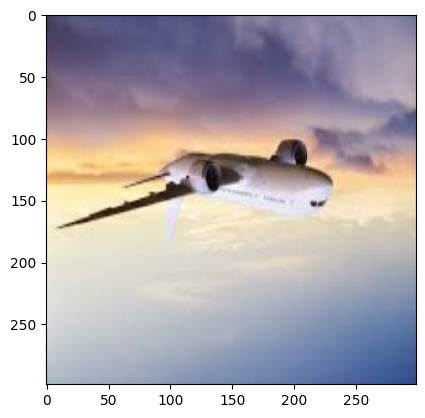

True label = Others
Predicted label = Others
1/1 [==============================] - 0s 301ms/step


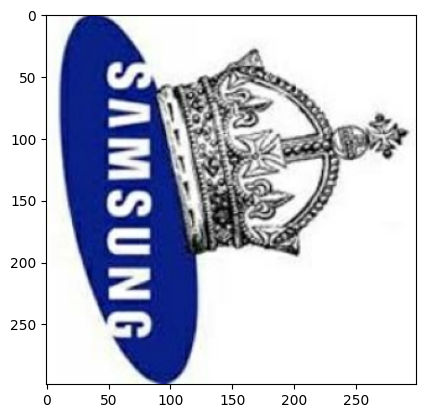

True label = Samsung
Predicted label = Samsung


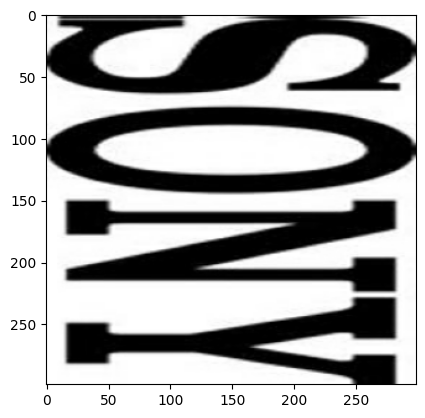

True label = Others
Predicted label = Others
1/1 [==============================] - 0s 308ms/step


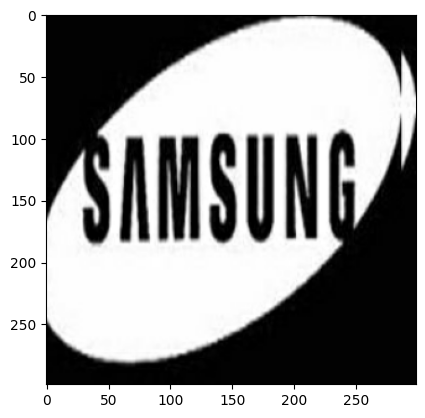

True label = Samsung
Predicted label = Samsung


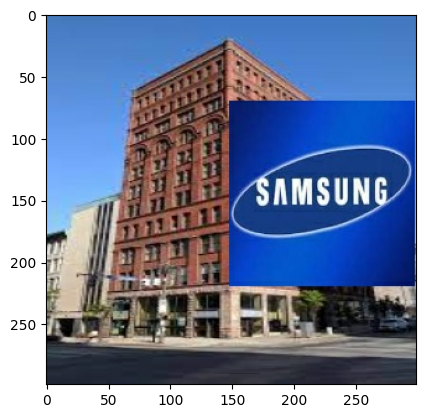

True label = Samsung
Predicted label = Samsung
1/1 [==============================] - 0s 324ms/step


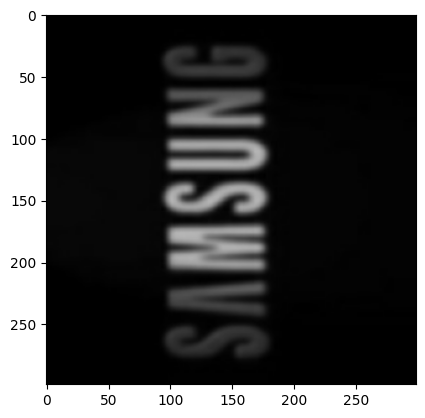

True label = Samsung
Predicted label = Samsung


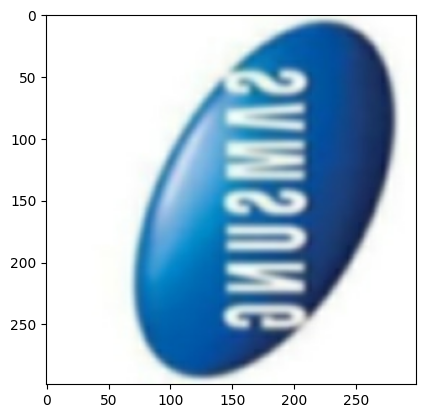

True label = Samsung
Predicted label = Samsung
1/1 [==============================] - 0s 405ms/step


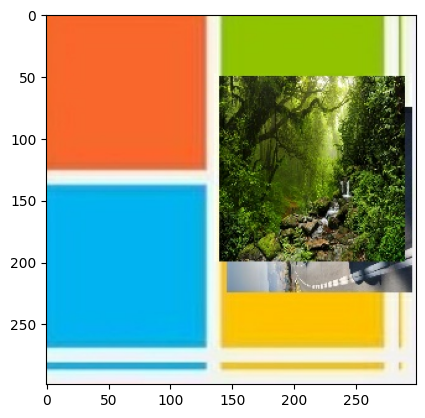

True label = Others
Predicted label = Others


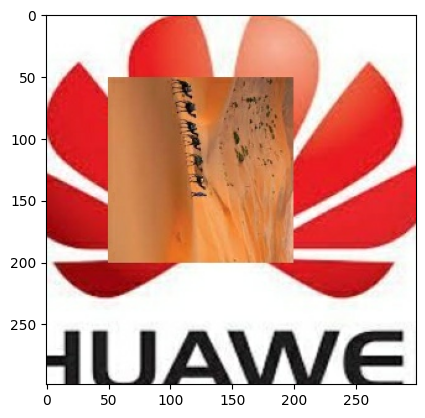

True label = Others
Predicted label = Others
1/1 [==============================] - 0s 352ms/step


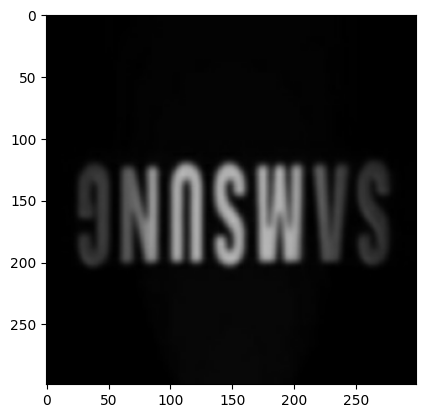

True label = Samsung
Predicted label = Samsung


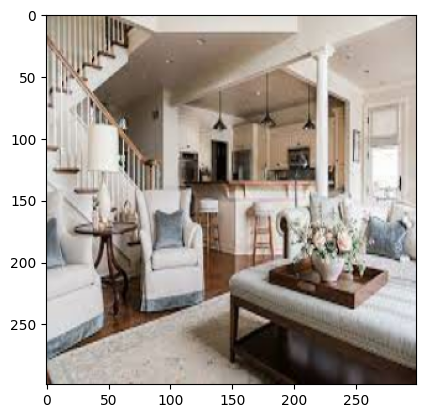

True label = Others
Predicted label = Others
1/1 [==============================] - 0s 350ms/step


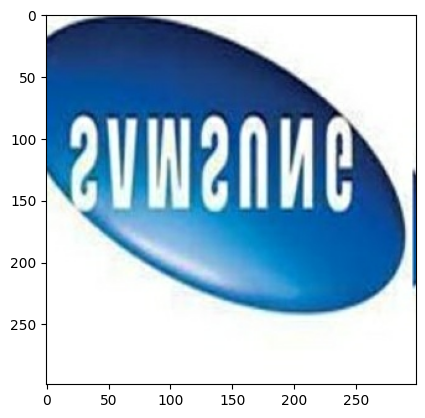

True label = Samsung
Predicted label = Samsung


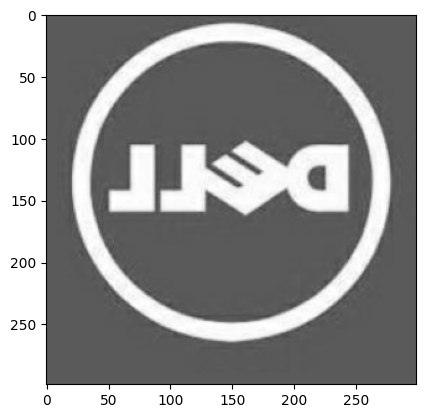

True label = Others
Predicted label = Others
1/1 [==============================] - 0s 340ms/step


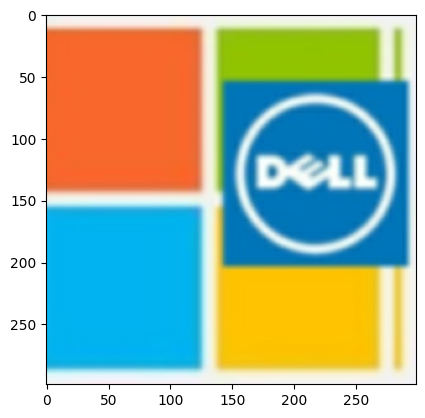

True label = Others
Predicted label = Others


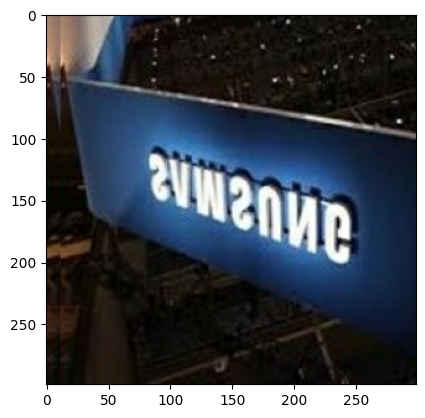

True label = Samsung
Predicted label = Samsung


In [25]:
for images, true_classes in test_ds.take(10):
    predictions = model.predict(images)
    true_class = true_classes.numpy()
    pred_class = np.round(predictions)
    for index, img in enumerate(images):
        img = img.numpy()
        imgplot = plt.imshow(images[index].numpy().astype('uint8'))
        plt.show()
        print('True label =', class_names[true_class[index]])
        print('Predicted label =', class_names[int(np.round(pred_class[index]))])
        if(index > 10):
            break

In [5]:
video = cv2.VideoCapture('Data/samsung.mp4')
frame_no = 0
last_predictions = []
last_result = False
begin_time = []
end_time = []
while video.isOpened():
    ret, frame = video.read()
    if(ret):
        frame_no += 1
        if(frame_no % 4 != 0):
            continue

        process_frame = preprocessor.preprocess_opencv_img(frame)
        process_frame = np.expand_dims(process_frame, axis = 0)
        predictions = model.predict(process_frame, verbose = 0)
        pred_class = predictions[0]
        last_predictions.append(pred_class)
        if(len(last_predictions) > 3):
            last_predictions.pop(0)
        avg_prediction = sum(last_predictions) / len(last_predictions)
        if(avg_prediction > 0.5 and not last_result):
            last_result = True
            time = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
            print("Start =", time)
            begin_time.append(time)
            
        if(avg_prediction < 0.5 and last_result):
            last_result = False
            time = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
            print("End =", time)
            begin_time.append(time)
        
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    else:
        cv2.destroyAllWindows()
        break

Start = 6.8999999999999995
End = 15.299999999999999
